# More on fitting sinusoidal models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Estimating Frequency in a Simulated Dataset

Consider the following dataset simulated using the model: 
\begin{equation*}
    y_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin( 2 \pi f t) + \epsilon_t,
\end{equation*}
for $t = 1, \dots, n$ with some fixed values of $f, \beta_0, \beta_1, \beta_2$ and $\sigma$. The goal of this problem is to estimate $f$ along with associated uncertainty quantification.  

In [2]:
f = 0.2
#f = 1.8
n = 400
b0 = 0
b1 = 3
b2 = 5
sig = 10

rng = np.random.default_rng()
errorsamples = rng.normal(loc = 0, scale = sig, size = n)
t = np.arange(1, n + 1)

y = b0 * np.ones(n) + b1 * np.cos(2 * np.pi * f * t) + b2 * np.sin(2 * np.pi * f * t) + errorsamples

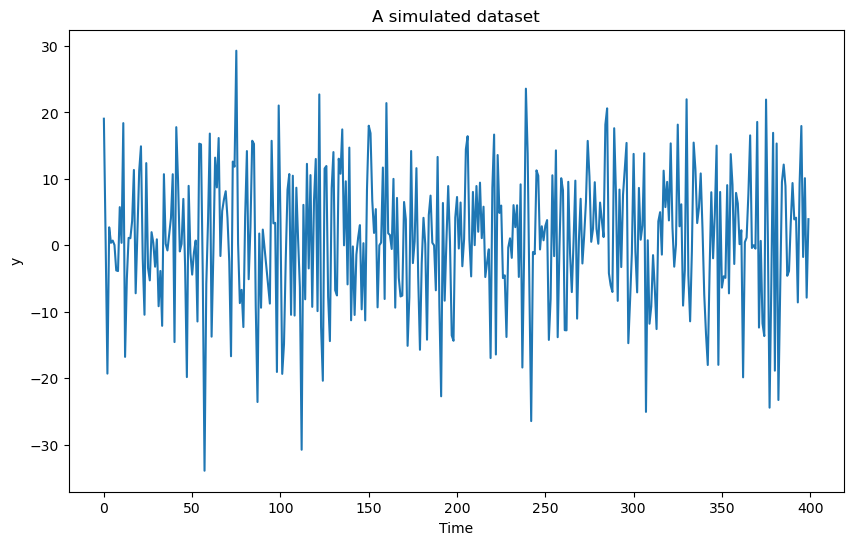

In [3]:
plt.figure(figsize = (10, 6))
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('A simulated dataset')
plt.show()

The frequentist solution calculates the MLE. For computing the MLE, we first optimize the following criterion function over $f$ to obtain $\hat{f}$:
\begin{equation*}
   \text{crit}(f) := \min_{\beta_0, \beta_1, \beta_2} \sum_{t=1}^n (y_t - \beta_0 - \beta_1 \cos(2 \pi f t) - \beta_2 \sin(2 \pi f t))^2 = RSS(f),
\end{equation*}
where $RSS(f)$ denotes the Residual Sum of Squares in the linear regression model obtaining by fixing $f$. After finding $\hat{f}$, the MLEs for the other parameters are obtained as in standard linear regression with $f$ fixed at $\hat{f}$.

In [4]:
def crit(f):
    x = np.arange(1, n + 1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    return rss

Here is a plot of $\text{crit}(f)$ as a function of $f$ over a grid of values of $f$. 

In [5]:
ngrid = 100000
allfvals = np.linspace(0, 0.5, ngrid)
critvals = np.array([crit(f) for f in allfvals])

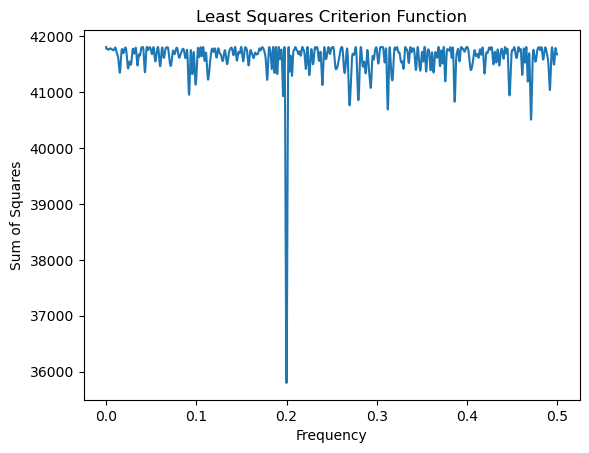

In [6]:
plt.plot(allfvals, critvals)
plt.xlabel('Frequency')
plt.ylabel('Sum of Squares')
plt.title('Least Squares Criterion Function')
plt.show()

In [7]:
# the MLE of f is now calculated as:
fhat = allfvals[np.argmin(critvals)]

print(fhat)

0.1998969989699897


After obtaining $\hat{f}$, the estimates of $\beta_0, \beta_1, \beta_2, \sigma$ are obtained in the usual way for linear regression fixing $f = \hat{f}$

In [8]:
x = np.arange(1, n + 1)
xcos = np.cos(2 * np.pi * fhat * x)
xsin = np.sin(2 * np.pi * fhat * x)
Xfhat = np.column_stack([np.ones(n), xcos, xsin])

md = sm.OLS(y, Xfhat).fit()

print(md.params) # this gives estimates of beta_0, beta_1, beta_2
print(md.summary())

[0.98353083 3.62686407 4.11283874]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     33.33
Date:                Fri, 07 Feb 2025   Prob (F-statistic):           4.16e-14
Time:                        17:35:53   Log-Likelihood:                -1466.4
No. Observations:                 400   AIC:                             2939.
Df Residuals:                     397   BIC:                             2951.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

The true values of $\beta_0, \beta_1, \beta_2$ lie in the corresponding 95\% C.I given for each coefficient in the model summary above. 

In [9]:
# Estimate of sigma:
rss = np.sum(md.resid ** 2)
sigmahat = np.sqrt(rss / (n - 3))

print(sigmahat)

9.495940890783043


Next we look at Bayesian inference which will yield similar results but will additionally provide uncertainty intervals for $f$. We use the following formula for the Bayesian posterior that we derived in class:
\begin{equation*}
   I\{0 \leq f \leq 1/2\} \cdot |X_f^T X_f|^{-1/2} \cdot \left(\frac{1}{S(\hat{\beta}(f), f)} \right)^{(n-p)/2}
\end{equation*}
where $p = 3$ and $|X_f^T X_f|$ denotes the determinant of $X_f^T X_f$. 

It is better to compute the logarithm of the posterior (as opposed to the posterior directly) because of numerical issues. 

In [10]:
def logpost(f):
    x = np.arange(1, n + 1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])

    p = X.shape[1]

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) # sgn gives the sign of the determinant (in our case, this should 1)
    # log_det gives the logarithm of the absolute value of the determinant
    logval = ((p - n) / 2) * np.log(rss) - 0.5 * log_det

    return logval

While evaluating the log posterior on a grid, it is important to make sure that we do not include frequencies $f$ for which $X_f^T X_f$ is singular. This will be the case for $f = 0$ and $f = 1/2$. When $f$ is very close to 0 or $0.5$, the term $|X_f^T X_f|^{-1/2}$ will be very large because of near-singularity of $X_f^T X_f$. We will therefore exclude frequencies very close to 0 and 0.5 from the grid while calculating posterior probabilities.  


In [11]:
logpostvals = np.array([logpost(f) for f in allfvals])

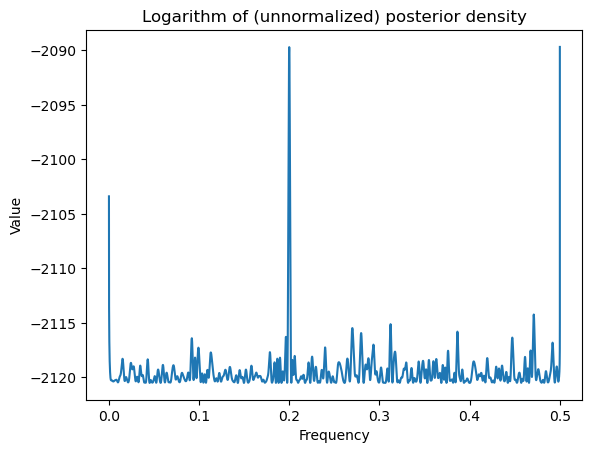

In [12]:
plt.plot(allfvals, logpostvals)
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show()

In [13]:
allfvals = allfvals[100:(ngrid - 100)]

print(np.min(allfvals), np.max(allfvals))

logpostvals = np.array([logpost(f) for f in allfvals])

0.0005000050000500005 0.49949999499995


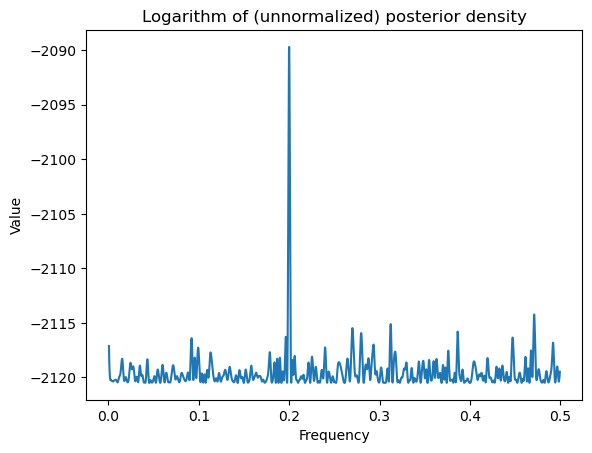

In [14]:
plt.plot(allfvals, logpostvals)
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show()

Next we exponentiate the log posterior to obtain posterior. Here we again need to be mindful of numerical issues. If we directly take the exponent of numbers, we might get 0 or $\infty$. So we first subtract a constant so that the values are somewhat closer to 0 before taking the exponent. 

In [15]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized / (np.sum(postvals_unnormalized))

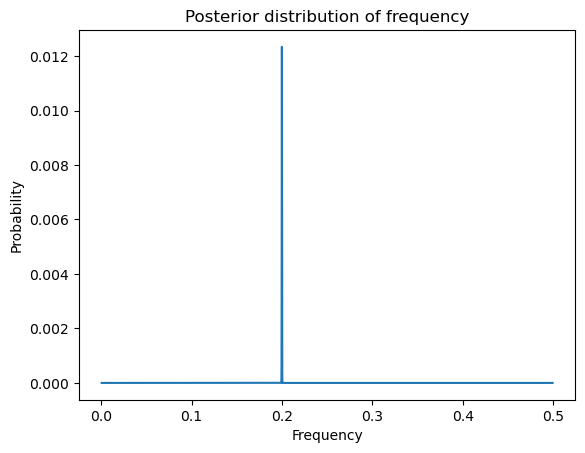

In [16]:
plt.plot(allfvals, postvals)
plt.xlabel('Frequency')
plt.ylabel('Probability')
plt.title('Posterior distribution of frequency')
plt.show()

In [17]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals_density = postvals_unnormalized / (np.sum(postvals_unnormalized))

postvals_density = postvals_density * (ngrid - 200) / 0.5

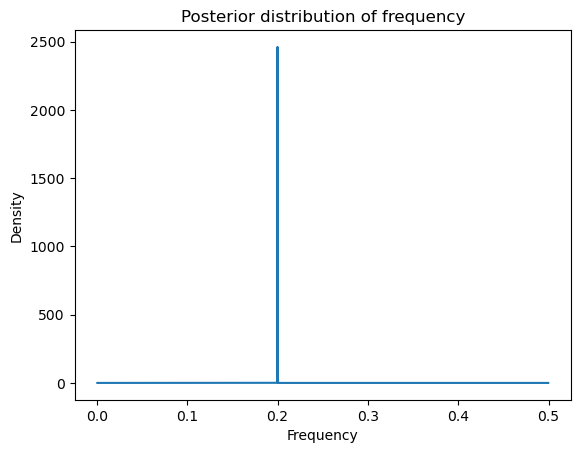

In [18]:
plt.plot(allfvals, postvals_density)
plt.xlabel('Frequency')
plt.ylabel('Density')
plt.title('Posterior distribution of frequency')
plt.show()

Using the posterior distribution, we can calculate posterior mean etc. and obtain credible intervals for $f$.

In [19]:
#Posterior mean of f:
fpostmean = np.sum(postvals * allfvals)

#Posterior mode of f:
fpostmode = allfvals[np.argmax(postvals)]

print(fpostmean, fpostmode, fhat)

0.19989514344518863 0.1998969989699897 0.1998969989699897


Note that the posterior mode coincides with the MLE. Let us now compute a credible interval for $f$. A 95\% credible interval is an interval for which the posterior probability is about 95\%. The following function takes an input value $m$ and compute the posterior probability assigned to the interval $\hat{f} - m*\delta, \hat{f} + m*\delta$ where $\delta$ is the grid resolution that we used for computing the posterior. 

In [20]:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind - m):(est_ind + m)])

    return(ans)

We now start with a small value of $m$ (say $m = 0$) and keep increasing it until the posterior probability reaches 0.95. 

In [21]:
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m + 1

print(m)

65


The credible interval for $f$ can then be computed in the following way.

In [22]:
est_ind = np.argmax(postvals)
f_est = allfvals[est_ind]

# 95% credible interval for f:
ci_f_low = allfvals[est_ind - m]
ci_f_high = allfvals[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))

[0.199897 0.199572 0.200222]


When I implemented this experiment, I found the interval to be very narrow while containing the true value 0.2.

## Frequency Aliasing

Now consider the same simulation setting as the previous problem but change the true frequency to $f = 1.8$ as opposed to $f = 0.2$. The analysis then would still yield an estimate which is close to 0.2. This is because the frequency $f_0 = 0.2$ is an alias of $f = 1.8$ in the sense that the two sinusoids $s_t = R \cos (2 \pi f t + \phi)$ and $s_t = R \cos (2 \pi f_0 t - \phi)$ are identical when $t$ is integer-valued. One can note that the estimate of $\beta_2$ will have a flipped sign however. 

It is very important to note that aliasing is a consequence of our time variable taking the equally spaced values $1, \dots, n$. If we change the time variable to some non-uniform values (i.e., if we sample the sinusoid at a non-uniform set of values), then it is possible to estimate frequencies which are outside of the range $[0, 0.5]$. This is illustrated below with $f = 1.8$. We take time to be randomly chosen points in the range $[1, n]$. 

In [23]:
#f = 0.2
f = 1.8
n = 400
b0 = 0
b1 = 3
b2 = 5
sig = 10

rng = np.random.default_rng()
errorsamples = rng.normal(loc = 0, scale = sig, size = n)

#t = np.arange(1, n+1)
t = np.sort(rng.uniform(low = 1, high = n, size = n))

y = b0 * np.ones(n) + b1 * np.cos(2 * np.pi * f * t) + b2 * np.sin(2 * np.pi * f * t) + errorsamples

In [24]:
print(t) # time again ranges roughly between 1 and 400 but this time the values are not equally spaced

[  1.56329304   2.62935633   3.79388205   3.88731761   3.96842364
   8.54831538  12.83284043  12.95440184  13.09019748  13.23596509
  13.79555142  15.78970998  16.20560962  16.55845882  17.62854352
  17.70651795  19.54620116  19.83031628  20.54486984  23.18637895
  23.38671572  23.81397752  24.9898303   25.74143453  25.75881811
  29.18087541  29.59926001  30.4469271   30.64392491  32.78771125
  33.39879012  35.79954741  36.01481776  38.23331734  39.61847301
  39.62225731  43.95909818  44.17443166  44.56023612  45.17267168
  45.43366364  45.6042612   45.83746185  46.45099859  47.43092162
  47.67447237  48.14188937  48.72066985  51.96628887  52.26213298
  52.9664796   53.79341652  56.9370232   58.68036218  60.94536298
  61.05123473  61.30366849  61.36256233  61.44770438  61.48514674
  62.47577464  62.75035     63.96443712  64.19456149  64.68668648
  67.27881048  67.57517322  67.96705953  70.36120275  70.79681197
  71.59398342  71.96867177  73.49774859  74.32638787  74.7989255
  75.227209

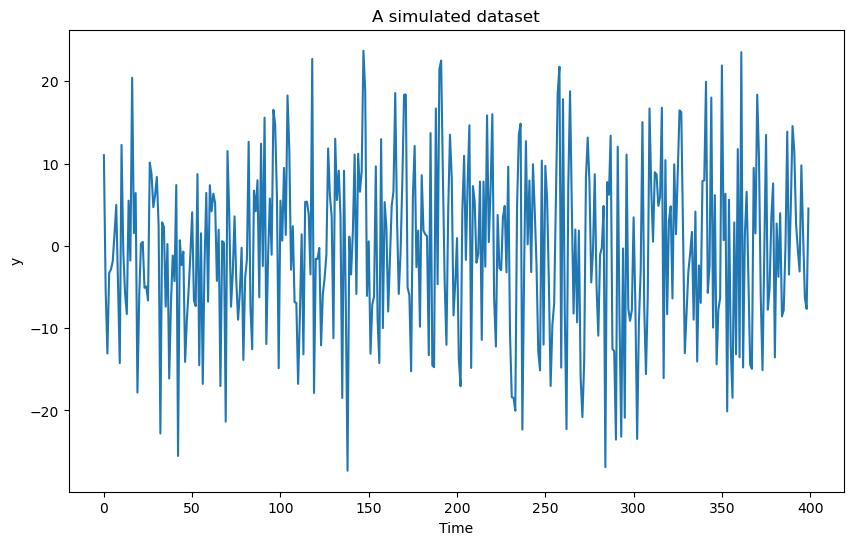

In [25]:
plt.figure(figsize = (10, 6))
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('A simulated dataset')
plt.show()

In [26]:
def crit(f):
    xcos = np.cos(2 * np.pi * f * t)
    xsin = np.sin(2 * np.pi * f * t)
    X = np.column_stack([np.ones(n), xcos, xsin])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    return rss

To evaluate the criterion function, we shall take the grid to be spaced over the larger range $[0, 10]$. Note that we cannot restrict the frequency parameter to $[0, 1/2]$ because time is not equally spaced. 

In [27]:
ngrid = 100000
allfvals = np.linspace(0, 10, ngrid)
critvals = np.array([crit(f) for f in allfvals])

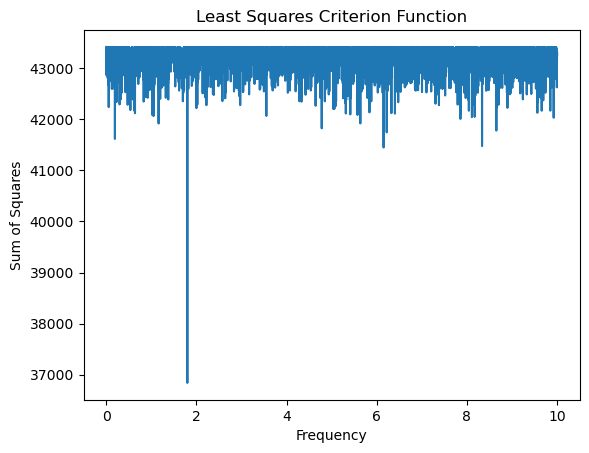

In [28]:
plt.plot(allfvals, critvals)
plt.xlabel('Frequency')
plt.ylabel('Sum of Squares')
plt.title('Least Squares Criterion Function')
plt.show()

In [29]:
# the MLE of f is now:
fhat = allfvals[np.argmin(critvals)]

print(fhat)

1.7996179961799619


Note that the MLE is very close to 1.8. The Bayesian analysis will also give a posterior that is tightly concentrated around 1.8.

In [30]:
def logpost(f):
    xcos = np.cos(2 * np.pi * f * t)
    xsin = np.sin(2 * np.pi * f * t)
    X = np.column_stack([np.ones(n), xcos, xsin])

    p = X.shape[1]

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) # sgn gives the sign of the determinant (in our case, this should 1)
    # log_det gives the logarithm of the absolute value of the determinant
    logval = ((p - n) / 2) * np.log(rss) - 0.5 * log_det

    return logval

0.01000010000100001 10.0


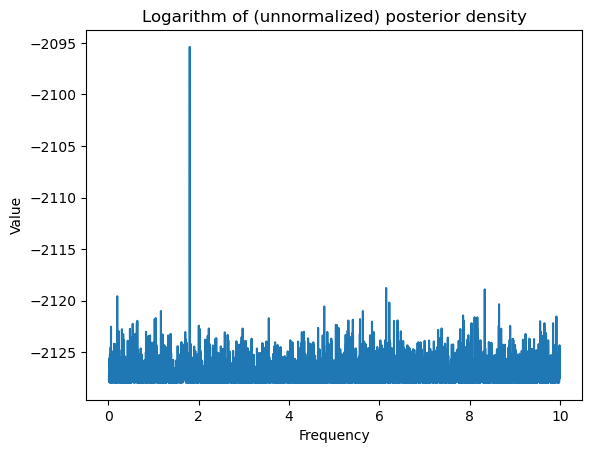

In [31]:
allfvals = allfvals[100:ngrid] # we are removing some values near 0 to prevent singularity of X_f^T X_f
print(np.min(allfvals), np.max(allfvals))

logpostvals = np.array([logpost(f) for f in allfvals])

plt.plot(allfvals, logpostvals)
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show()

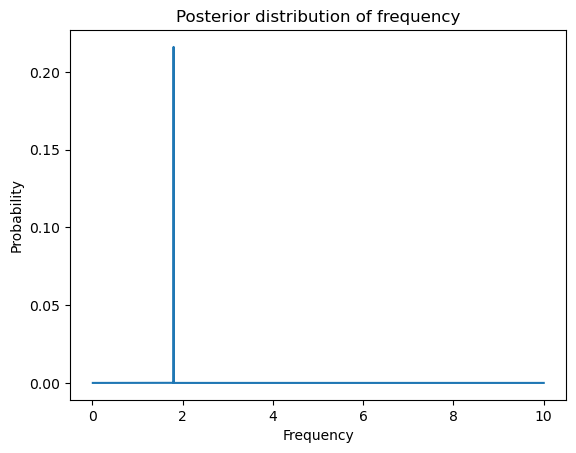

In [32]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized / (np.sum(postvals_unnormalized))

plt.plot(allfvals, postvals)
plt.xlabel('Frequency')
plt.ylabel('Probability')
plt.title('Posterior distribution of frequency')
plt.show()

In [33]:
# Posterior mean of f:
fpostmean = np.sum(postvals * allfvals)

# Posterior mode of f:
fpostmode = allfvals[np.argmax(postvals)]

print(fpostmean, fpostmode, fhat)

1.7995875783285253 1.7996179961799619 1.7996179961799619
